## Self-Organizing Maps

The Self Organizing Maps developed by KOHONEN (1982) is a neural network, which mimics the functioning of the Cerebral Cortex, and characterized by being a single layer network. The figure below shows the topography of the Nueral Network, where we have the input samples, the Neural Network (Cortex) and the weights connecting each sample to each of the Nuronium Network.

<img src="./figures/latent_space.png"></img>

Self Organization Maps (SOM) algorithm training is typically divided into two stages: competitive and cooperative. The figure below shows the dynamics between the SOM network and the samples (purple cloud).

Competition: in this stage, the winning neuron with the best correspondence in relation to the input data is selected, figure (a).

Cooperation: here, the weights of the winner are adapted, as well as those of the immediate neighboring neurons of the network, figure (b).

After several iterations, the Neurons have new weights and the neural network manages to represent the samples, (figure c).


<img src="./figures/algorithm.png"></img>

                   (a)                             (b)                              (c)


## Algoritmo

The SOM algorithm can be described in the following steps:

1. Initialize the neurons ($\mathbf{w}$) in the parameter space

2. Select a random sample of data ($\mathbf{x}$): $\mathbf{x}_n$

3. Find the most similar neuron to this sample (best-matching unit, BMU)

    $$BMU = \underset{j}{\arg \min} \left \| \mathbf{x}_n - \mathbf{w}_j \right \|$$

4. Adjust excited neurons:

    $$\Delta \mathbf{w}^{n} = \alpha(n) \cdot h(D(\mathbf{w}_{BMU},\mathbf{w}), n) \otimes (\mathbf{ x}_n - \mathbf{w}^{n})$$
    $$\mathbf{w}^{n+1} = \mathbf{w}^{n} + \Delta \mathbf{w}^{n}$$

5. Repeat from step 2 until reaching the stopping criterion

Where $n$ is the algorithm step, $\alpha$ is the learning rate and $h$ is the neighborhood function.


In [1]:
import numpy as np
from math import sqrt
import pandas as pd
import scipy as sp
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib import animation, colors
import Self_Organizing_Maps


In [2]:
# UTILIZAÇÃO DO APPYNHO PARA FAZER GRÁFICOS DE PERFIS:
#---------------------
import sys
sys.path.insert(0,'modules')
import imod
from appynho_2 import plotagem as plm2

## Loading well-log 1 for training:

In [3]:
cab = ['etiquetas','prof','rhob', 'gr', 'dt']
data = pd.read_csv('arq2.txt', sep='\s+',
                     skiprows=1, names = cab, usecols=(0,1,2,3,4) )

In [4]:
data

,etiquetas,prof,rhob,gr,dt
0,2,4.47,2.72,75.0,72.8
1,2,4.54,2.75,78.0,65.6
2,2,4.61,2.83,84.2,62.5
3,2,4.69,2.68,84.0,70.4
4,2,4.76,2.81,81.9,59.5
...,...,...,...,...,...
832,3,63.60,1.89,25.1,72.5
833,3,63.70,1.91,17.3,55.8
834,3,63.70,1.88,21.0,65.6
835,3,63.80,1.89,18.7,64.4


#### Distribution of data in crossplots:

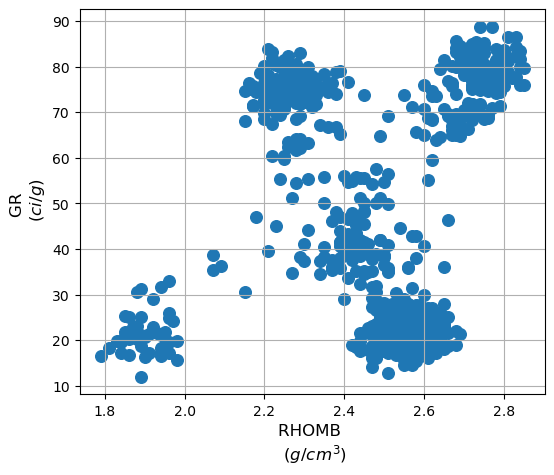

In [5]:
plt.close('all')
plt.figure(figsize=(6,5))

plt.scatter(data['rhob'], data['gr'], s=70, alpha=1.0) 

plt.xlabel('RHOMB \n $(g/cm^{3})$', fontsize = 12)
plt.ylabel('GR \n $(ci/g$)', fontsize = 12)
plt.grid(True)
plt.show()

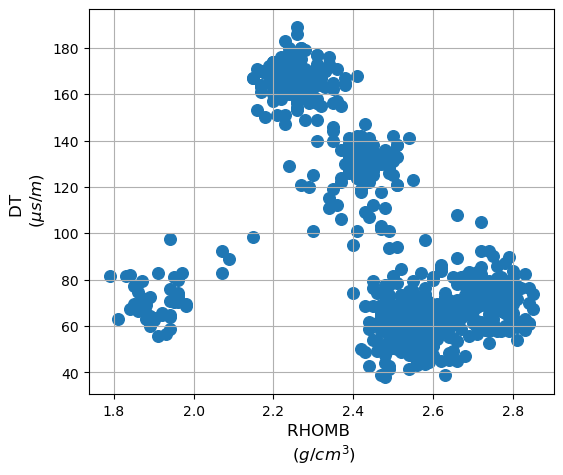

In [6]:
plt.close('all')
plt.figure(figsize=(6,5))

plt.scatter(data['rhob'], data['dt'], s=70, alpha=1.0) 

plt.xlabel('RHOMB \n $(g/cm^{3})$', fontsize = 12)
plt.ylabel('DT \n $(\mu s/m)$', fontsize = 12)
plt.grid(True)
plt.show()

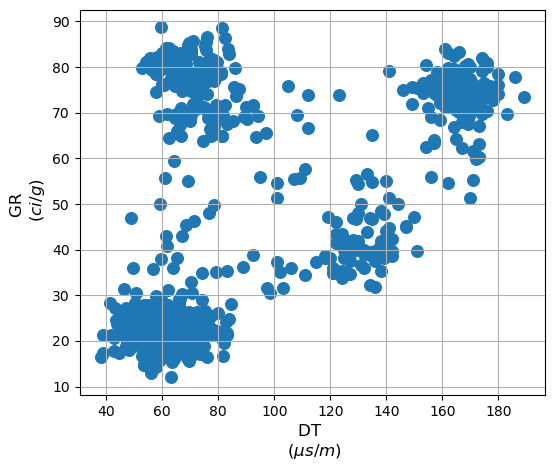

In [7]:
plt.close('all')
plt.figure(figsize=(6,5))

plt.scatter(data['dt'], data['gr'], s=70, alpha=1.0) 

plt.xlabel('DT \n $(\mu s/m)$', fontsize = 12)
plt.ylabel('GR \n $(ci/g$)', fontsize = 12)
plt.grid(True)
plt.show()

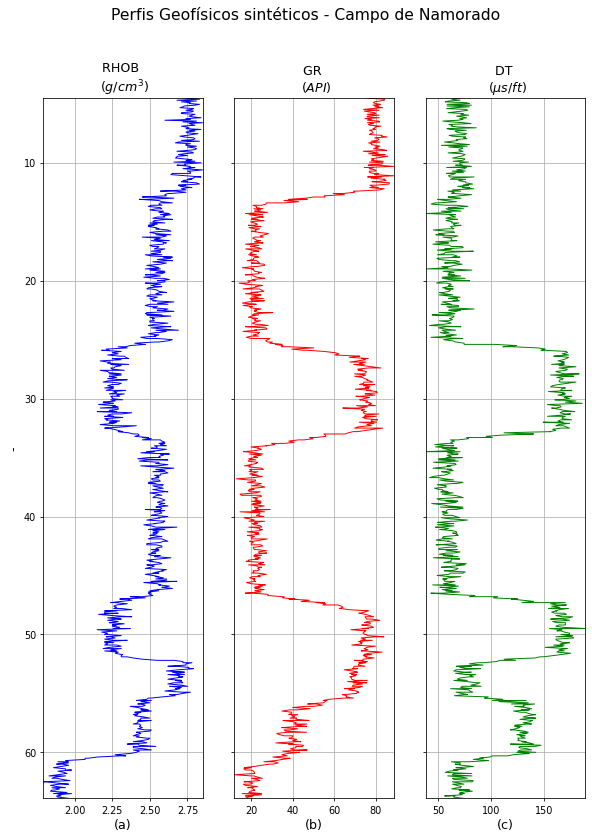

In [8]:
def order(x):
    """Cria uma lista começando do zero com o mesmo tamanho do dicionario"""
    r= [0]
    for i in range(x-1):
        i=i+1
        r.append(i)
    return r
    

# Gerando a imagem do poço

padrao={'comprimento':10,
            'altura':13,
        'titulo_geral': 'Perfis Geofísicos sintéticos - Campo de Namorado'
         }


#figure2 = plm2(3, padrao) 
figure2 = plm2(3, padrao)

figure2.plot_s(0,data['rhob'],data['prof'],
                   {'titulo':'RHOB \n $(g/cm^{3})$','cor':'b','descricao_x':'(a)'})

figure2.plot_s(1,data['gr'],data['prof'],
                   {'titulo':'GR \n $(API)$','cor':'r','descricao_x':'(b)'})

figure2.plot_s(2,data['dt'],data['prof'],
                   {'titulo':'DT \n $(\mu s/ft)$','cor':'g','descricao_x':'(c)'})


In [9]:
data_x = np.zeros((len(data), 3))
data_x.shape

(837, 3)

### Splitting data into training and labels:


In [10]:
data_x[:,0] = Self_Organizing_Maps.norm_data(data['rhob'])
data_x[:,1] = Self_Organizing_Maps.norm_data(data['gr'])
data_x[:,2] = Self_Organizing_Maps.norm_data(data['dt'])
data_x

array([[0.87735849, 0.82138201, 0.22995361],
       [0.90566038, 0.86049544, 0.18223989],
       [0.98113208, 0.94132986, 0.16169649],
       ...,
       [0.08490566, 0.11734029, 0.18223989],
       [0.09433962, 0.08735332, 0.17428761],
       [0.16037736, 0.06779661, 0.23392975]])

In [11]:
data_y = np.array(data['etiquetas'])

In [12]:
# train and test split
train_x, test_x, train_y, test_y = train_test_split(data_x, data_y, test_size=0.2, random_state=42)
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape) # check the shapes

(669, 3) (669,) (168, 3) (168,)


### Using the SOM function from ".py" file:

In [13]:
# hyperparameters
n_rows = 12
n_cols = 12
max_distance = 3.
max_learning_rate = 1 #0.5
max_epochs = int(2000)
t = np.random.randint(0,high=train_x.shape[0]) # random index of traing data

#### Applying SOM with 3 different settings in metric and neighborhood

#### SOM with Euclidean metrics and linear neighborhood:

In [14]:
# "SOM_train" performs the competition, cooperation and updating
# of the neurons using the training data.
# It returns the weight of neurons updated after iterations, 
# stored in the variable "updated_som1".

updated_som1 = Self_Organizing_Maps.SOM_train(n_rows, 
                                              n_cols, 
                                              max_epochs, 
                                              max_learning_rate, 
                                              max_distance, 
                                              train_x, 
                                              train_y, 
                                              learn='linear', 
                                              neigh='linear', 
                                              metric='euclidian')

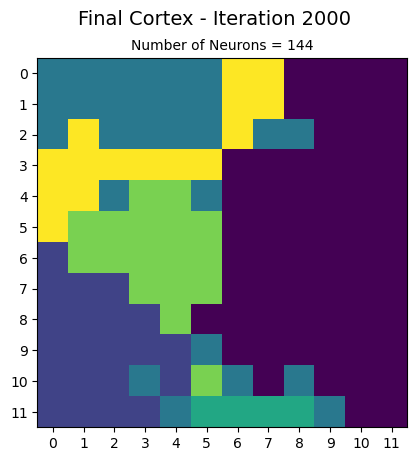

In [15]:
# "Cortex_map" shows the final Cortex showing the formed neighborhoods (same colors),
# using the adjusted weights "updated_som1"

label_map1 = Self_Organizing_Maps.Cortex_map(train_y, 
                                             train_x, 
                                             updated_som1,
                                             max_epochs, 
                                             metric='euclidian')

In [16]:
# "SOM_class" classifies test data from step learning with "SOM_train". 
# Using association between neuron weight labels (updated_som1 + label_map1) and 
# test data property values (test_x).

index1 = Self_Organizing_Maps.SOM_class(test_x, 
                                        updated_som1, 
                                        label_map1, 
                                        metric='euclidian')

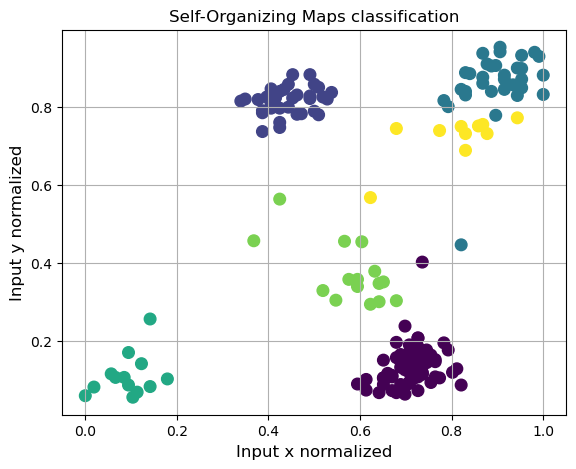

In [17]:
# "Crossplot" classification of data using two properties

Self_Organizing_Maps.Crossplot(index1, test_x, 0, 1)

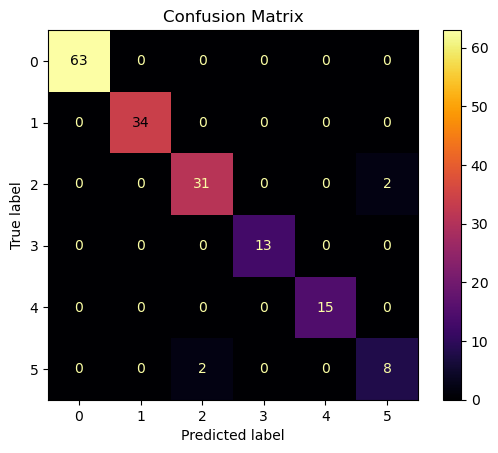

In [18]:
# "Confusion matrix" shows how well the test data was classified. 
# The more diagonal, means the better the classification 
# (comparison between actual and predicted labels)

conf_matrix = confusion_matrix(test_y, index1)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) #, display_labels=ind)
vis.plot(cmap='inferno')
plt.title('Confusion Matrix')
plt.show()

#### SOM with Euclidean metric and Gaussian neighborhood:

In [19]:
# "SOM_train" performs the competition, cooperation and updating
# of the neurons using the training data.
# It returns the weight of neurons updated after iterations, 
# stored in the variable "updated_som2".

updated_som2 = Self_Organizing_Maps.SOM_train(n_rows, 
                                              n_cols, 
                                              max_epochs, 
                                              max_learning_rate, 
                                              max_distance, 
                                              train_x, 
                                              train_y, 
                                              learn='linear', 
                                              neigh='gaussian', 
                                              metric='euclidian')

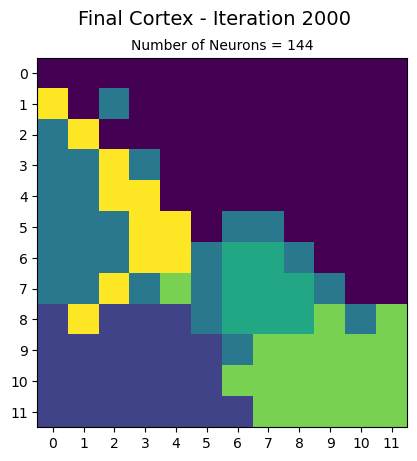

In [20]:
# "Cortex_map" shows the final Cortex showing the formed neighborhoods (same colors),
# using the adjusted weights "updated_som2"

label_map2 = Self_Organizing_Maps.Cortex_map(train_y, 
                                             train_x, 
                                             updated_som2,
                                             max_epochs, 
                                             metric='euclidian')

In [21]:
# "SOM_class" classifies test data from step learning with "SOM_train". 
# Using association between neuron weight labels (updated_som2 + label_map2) and 
# test data property values (test_x).

index2 = Self_Organizing_Maps.SOM_class(test_x, 
                                        updated_som2, 
                                        label_map2, 
                                        metric='euclidian')

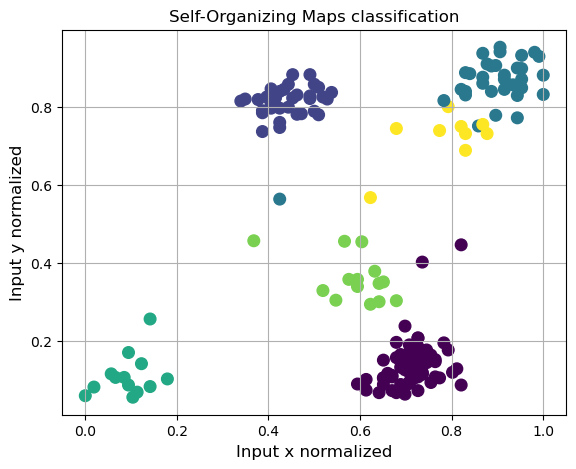

In [22]:
# "Crossplot" classification of data using two properties

Self_Organizing_Maps.Crossplot(index2, test_x, 0, 1)

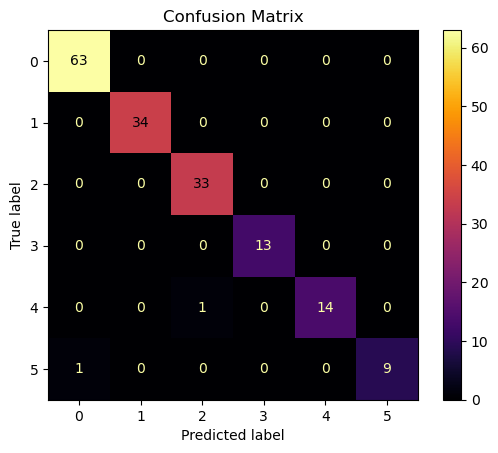

In [23]:
# "Confusion matrix" shows how well the test data was classified. 
# The more diagonal, means the better the classification 
# (comparison between actual and predicted labels)

conf_matrix = confusion_matrix(test_y, index2)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) #, display_labels=ind)
vis.plot(cmap='inferno')
plt.title('Confusion Matrix')
plt.show()

#### SOM with Manhattan metric and linear neighborhood:

In [24]:
# "SOM_train" performs the competition, cooperation and updating
# of the neurons using the training data.
# It returns the weight of neurons updated after iterations, 
# stored in the variable "updated_som3".

updated_som3 = Self_Organizing_Maps.SOM_train(n_rows, 
                                              n_cols, 
                                              max_epochs, 
                                              max_learning_rate, 
                                              max_distance, 
                                              train_x, 
                                              train_y, 
                                              learn='linear', 
                                              neigh='linear', 
                                              metric='manhattan')

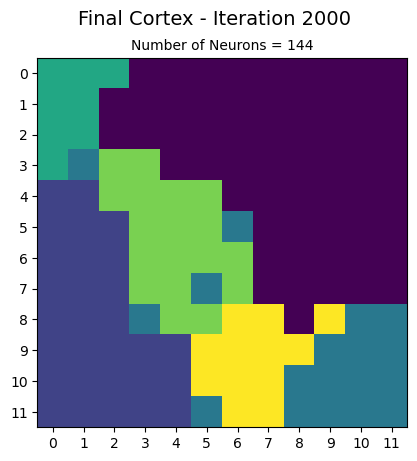

In [25]:
# "Cortex_map" shows the final Cortex showing the formed neighborhoods (same colors),
# using the adjusted weights "updated_som3"

label_map3 = Self_Organizing_Maps.Cortex_map(train_y, 
                                             train_x, 
                                             updated_som3,
                                             max_epochs, 
                                             metric='manhattan')

In [26]:
# "SOM_class" classifies test data from step learning with "SOM_train". 
# Using association between neuron weight labels (updated_som3 + label_map3) and 
# test data property values (test_x).

index3 = Self_Organizing_Maps.SOM_class(test_x, 
                                        updated_som3, 
                                        label_map3, 
                                        metric='manhattan')

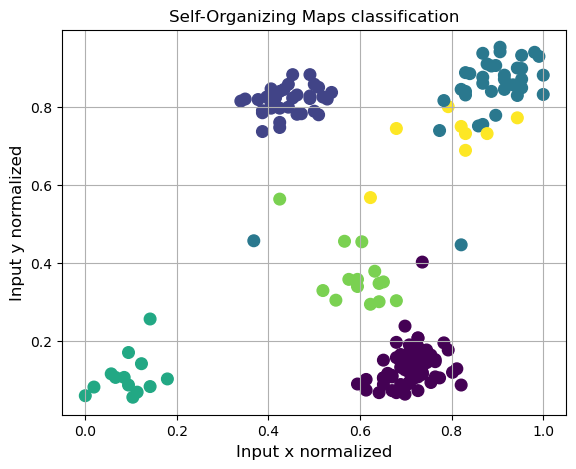

In [27]:
# "Crossplot" classification of data using two properties

Self_Organizing_Maps.Crossplot(index3, test_x, 0, 1)

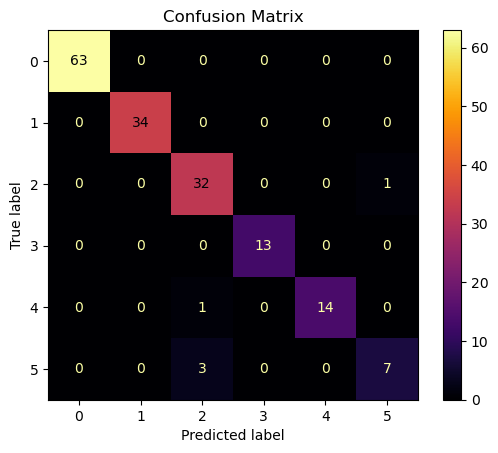

In [28]:
# "Confusion matrix" shows how well the test data was classified. 
# The more diagonal, means the better the classification 
# (comparison between actual and predicted labels)

conf_matrix = confusion_matrix(test_y, index3)
vis = ConfusionMatrixDisplay(confusion_matrix=conf_matrix) #, display_labels=ind)
vis.plot(cmap='inferno')
plt.title('Confusion Matrix')
plt.show()

## Loading of well-log 2 for classification:

In [29]:
cab = ['prof','rhob', 'gr', 'dt']
data_2 = pd.read_csv('arq4_09-05.txt', sep='\s+',
                     skiprows=1, names = cab, usecols=(0,1,2,3) )

In [30]:
data_class = np.zeros((len(data_2), 3))
data_class.shape

(597, 3)

In [31]:
### Data normalization:

data_class[:,0] = Self_Organizing_Maps.norm_data(data_2['rhob'])
data_class[:,1] = Self_Organizing_Maps.norm_data(data_2['gr'])
data_class[:,2] = Self_Organizing_Maps.norm_data(data_2['dt'])
data_class

array([[0.85981308, 0.88211382, 0.05852417],
       [0.88785047, 0.95799458, 0.10496183],
       [0.82242991, 0.86856369, 0.15394402],
       ...,
       [0.07476636, 0.1395664 , 0.15330789],
       [0.05607477, 0.07859079, 0.11450382],
       [0.01869159, 0.06639566, 0.22201018]])

#### Using Cortex from the training step:

In [32]:
# Using "SOM_class" to classify test data. 
# The comparison is now made between the 
# weights and properties of the new well-log data

index = Self_Organizing_Maps.SOM_class(data_class, 
                                        updated_som2, 
                                        label_map2, 
                                        metric='euclidian')

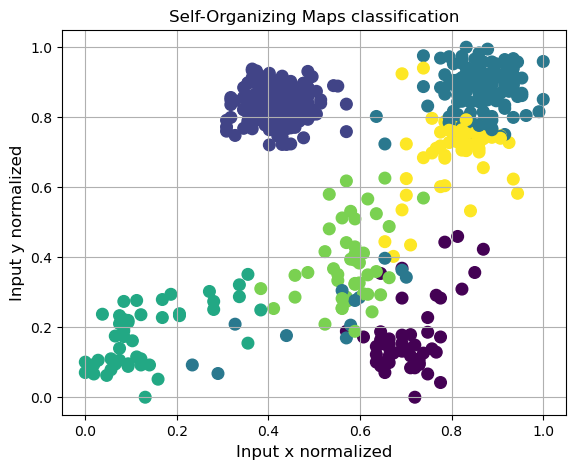

In [33]:
# "Crossplot" classification of data (well-log 2) using two properties 

Self_Organizing_Maps.Crossplot(index, data_class, 0, 1)

### Image with the original groups formed by synthetic data modeling for comparison!

##### -> different colors but the formed groups are similar!

##### -> plot below is not normalized!

In [34]:
from PIL import Image

image = Image.open('RHOxGR_p2originaldisper_09-05.png')

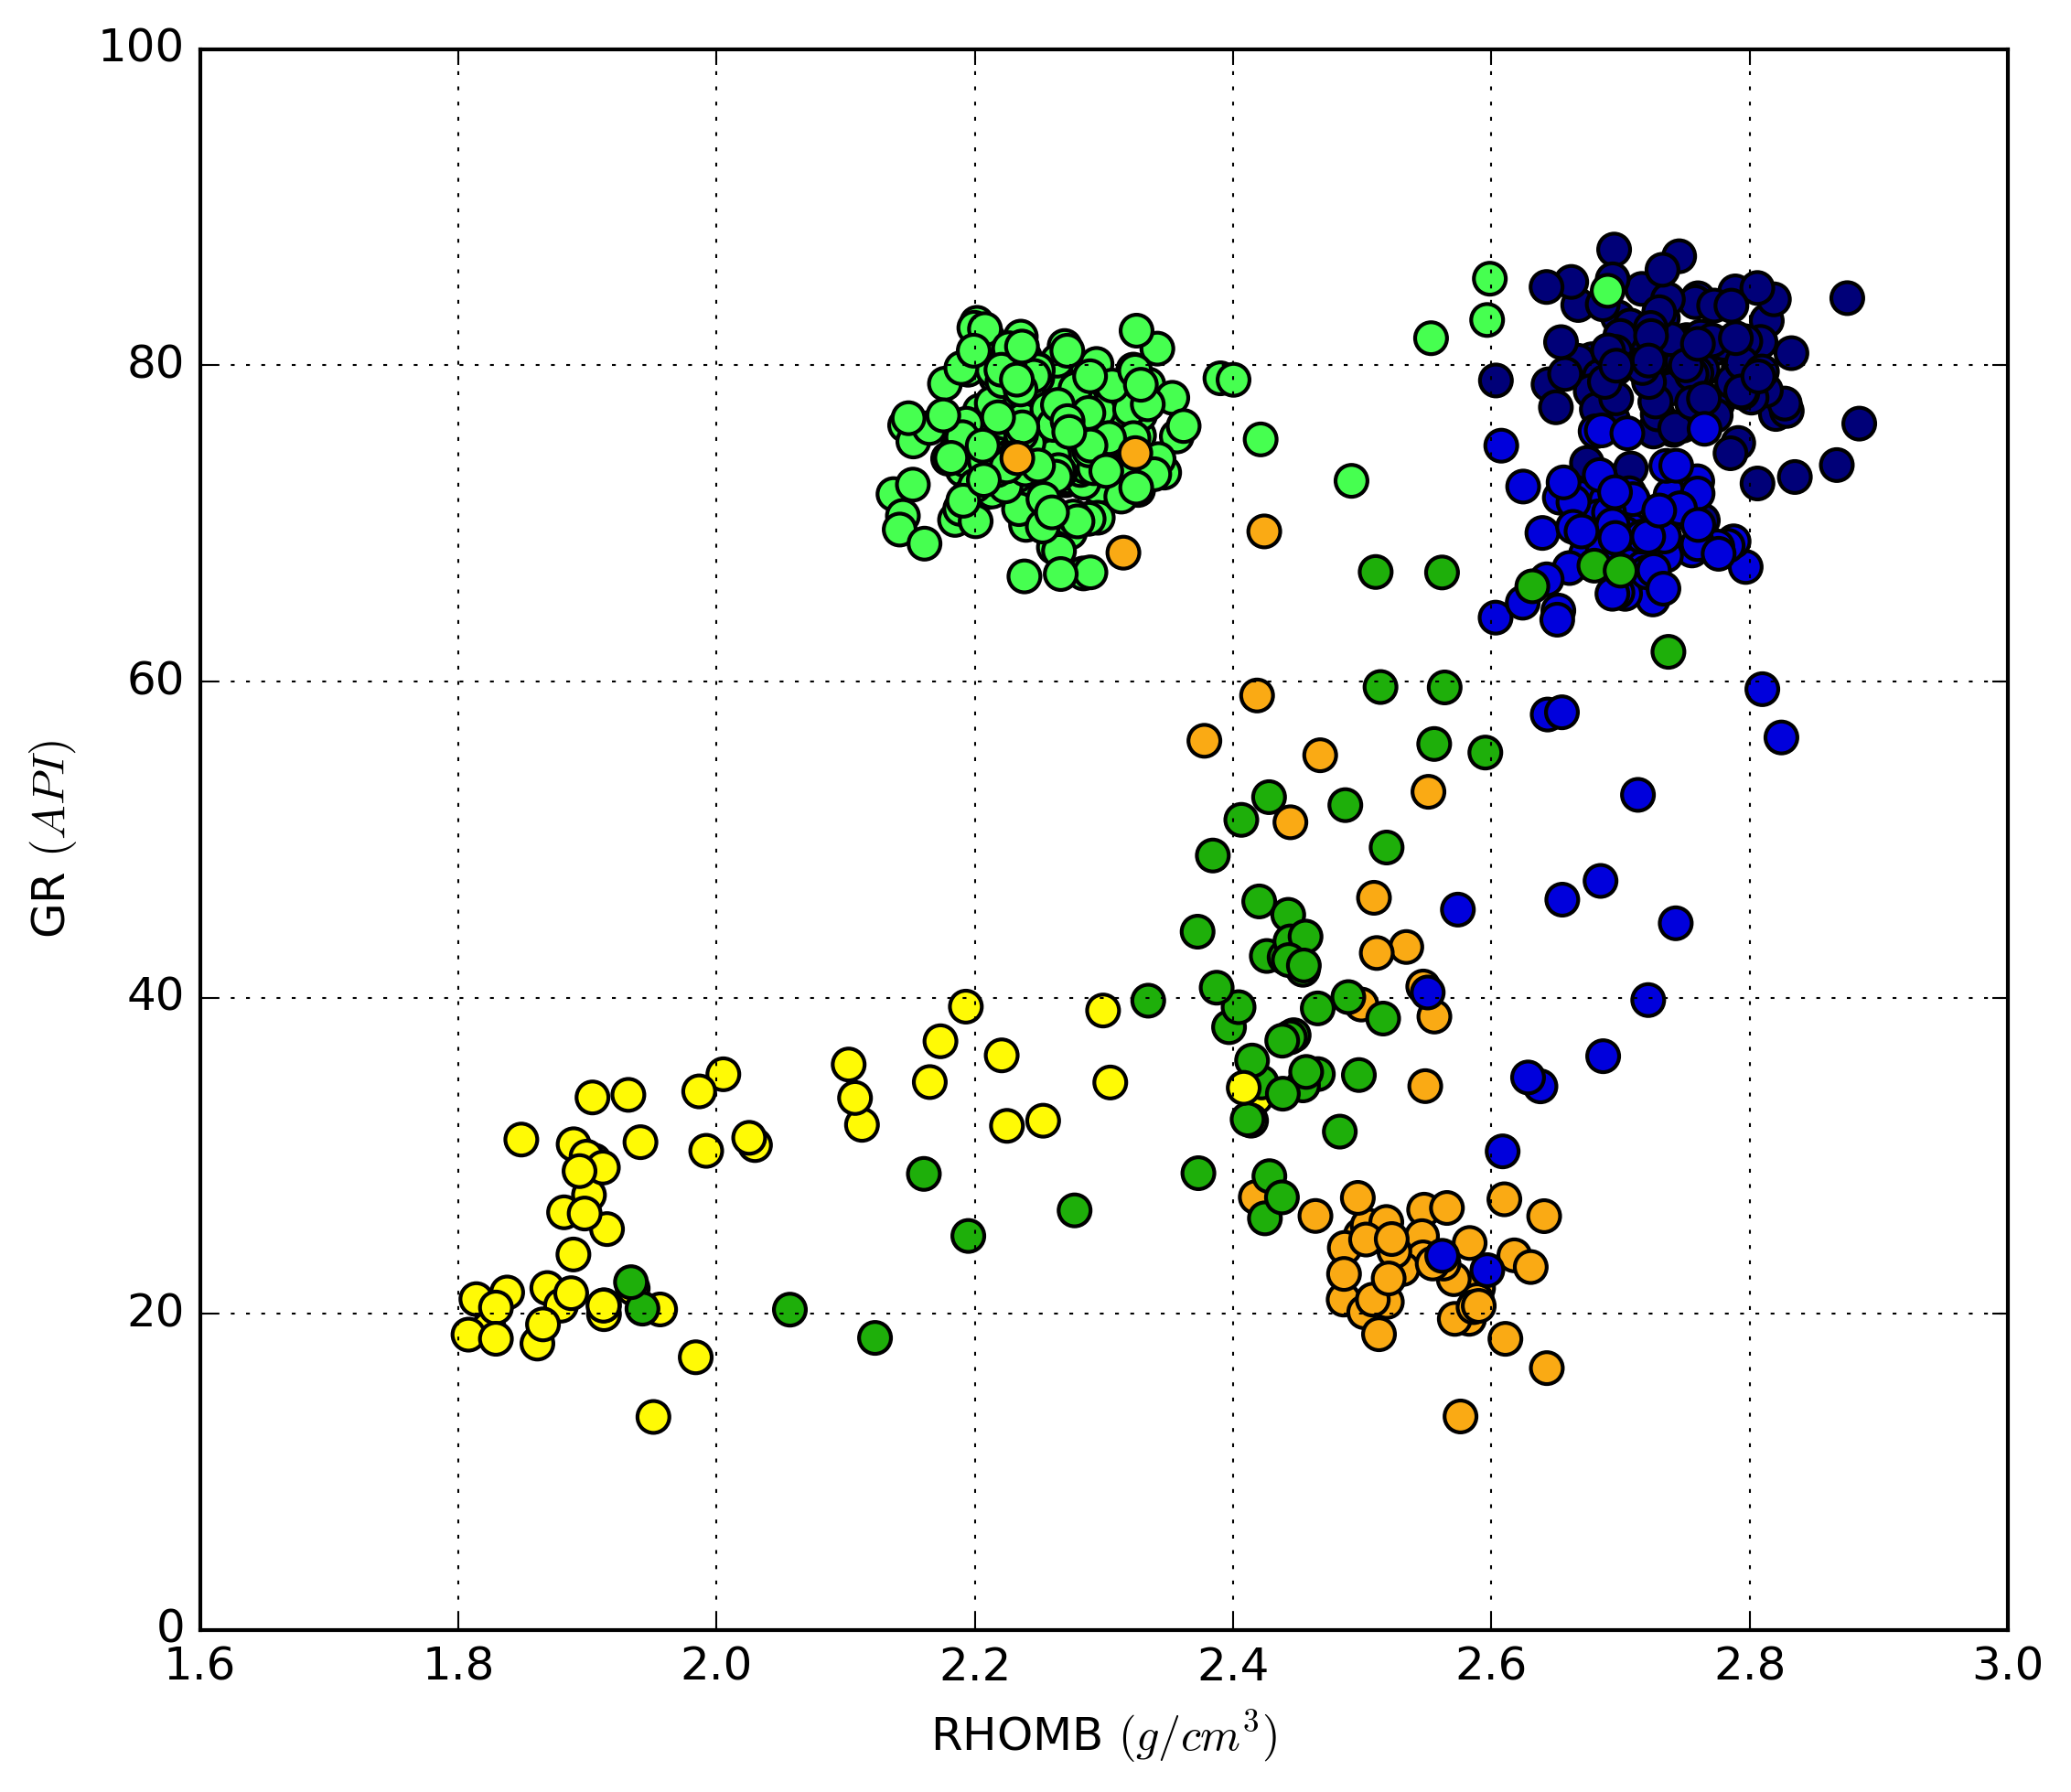

In [35]:
image

### END